<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#DLA---Diffusion-limited-aggregation" data-toc-modified-id="DLA---Diffusion-limited-aggregation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>DLA - Diffusion-limited aggregation</a></span></li><li><span><a href="#Old-version-(very-slow)" data-toc-modified-id="Old-version-(very-slow)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Old version (very slow)</a></span></li></ul></div>

In [1]:
# Pkg.clone("https://github.com/goropikari/LinuxNotifier.jl")
using Plots, ProgressMeter, BenchmarkTools, LinuxNotifier
pyplot(axis=false, colorbar=false, size=(200,200), leg=false, c=:blues)

Plots.PyPlotBackend()

# DLA - Diffusion-limited aggregation

In [2]:
abstract type System2D end

mutable struct Particle
    fix::Bool
    x::Int
    y::Int

    function Particle(x,y)
        new(false, x, y)
    end
end

mutable struct Parameters
    L::Int    # linear size of lattice
    r::Real   # radius of starting point
    N::Int    # number of random walker
    step::Int # maximum iteration number
    ct::Int   # number of attached random walker

    function Parameters(L, r, N, step)
        return new(L, r, N, step, 0)
    end
end

mutable struct DLAPlane <: System2D
    parameters::Parameters
    particles::Vector{Particle}
    site::Matrix{Bool}

    function DLAPlane(L::Int, r::Real, N::Int, step::Int)
        cen = div(L,2)
        particles = [Particle(round(Int, cen + r*cos(θ)), cen + round(Int, r*sin(θ))) 
                    for θ in linspace(0,2π, N)]
        
        site = falses(L, L)
        site[cen, cen] = true
        
        return new(Parameters(L, r, N, step), particles, site)
    end
end

mutable struct Bonsai <: System2D
    parameters::Parameters
    particles::Vector{Particle}
    site::Matrix{Bool}

end

function Bonsai(L::Int, N::Int, step::Int)
    site = falses(L, L)
    site[:,1] = true

    particles = [Particle(mod1(i, L), div(L,2)) for i in 1:N]

    return Bonsai(Parameters(L, r, N, step), particles, site)
end

# function updatepos!(system::DLAPlane)
#     dir = Dict(1=>(1,0), 2=>(-1,0), 3=>(0,1), 4=>(0,-1))
#     site = system.site
#     L = system.parameters.L
#     for particle in system.particles
#         if particle.fix
#             continue
#         end

#         x, y = particle.x, particle.y
#         a, b = dir[rand(1:4)]
#         x += a
#         y += b

#         x = mod1(x, L)
#         y = mod1(y, L)

#         if site[mod1(x+1, L), y] || site[mod1(x-1, L), y] || site[x, mod1(y+1, L)] || site[x, mod1(y-1, L)]
#             particle.fix = true
#             site[x,y] = true
#             system.parameters.ct += 1
#         end

#         particle.x, particle.y = x, y
#     end
    
#     return
# end

# function updatepos!(system::Bonsai)
#     dir = Dict(1=>(1,0), 2=>(-1,0), 3=>(0,1), 4=>(0,-1))
#     site = system.site
#     L = system.parameters.L
#     for particle in system.particles
#         if particle.fix
#             continue
#         end

#         x, y = particle.x, particle.y
#         a, b = dir[rand(1:4)]
#         x += a
#         y += b

#         x = mod1(x, L)
#         y = ifelse(y == L+1, L, y)

#         if site[mod1(x+1, L), y] || site[mod1(x-1, L), y] || site[x, ifelse(y+1 > L, L, y+1)] || site[x, y-1]
#             particle.fix = true
#             site[x,y] = true
#             system.parameters.ct += 1
#         end

#         particle.x, particle.y = x, y
#     end
    
#     return
# end

function updatepos!(system::System2D)
    dir = Dict(1=>(1,0), 2=>(-1,0), 3=>(0,1), 4=>(0,-1))
    site = system.site
    L = system.parameters.L
    for particle in system.particles
        if particle.fix
            continue
        end

        x, y = particle.x, particle.y
        a, b = dir[rand(1:4)]
        x += a
        y += b

        x = mod1(x, L)
        if typeof(system) == DLAPlane
            y = mod1(y, L)
            neigh = site[mod1(x+1, L), y] || site[mod1(x-1, L), y] || site[x, mod1(y+1, L)] || site[x, mod1(y-1, L)]
        elseif typeof(system) == Bonsai
            y = ifelse(y == L+1, L, y)
            neigh = site[mod1(x+1, L), y] || site[mod1(x-1, L), y] || site[x, ifelse(y+1 > L, L, y+1)] || site[x, y-1]
        end

##         consume a lot of memory
#         if typeof(system) == DLAPlane
#             y = mod1(y, L)
#             neigh = any([ site[mod1(x+1, L), y], site[mod1(x-1, L), y], site[x, mod1(y+1, L)], site[x, mod1(y-1, L)] ])
#         elseif typeof(system) == Bonsai
#             y = ifelse(y == L+1, L, y)
#             neigh = any([site[mod1(x+1, L), y], site[mod1(x-1, L), y], site[x, ifelse(y+1 > L, L, y+1)], site[x, y-1]])
#         end

        if neigh
            particle.fix = true
            site[x,y] = true
            system.parameters.ct += 1
        end

        particle.x, particle.y = x, y
    end
    
    return
end

function DLA!(system::System2D)
    step = system.parameters.step
    N = system.parameters.N
    
    @time @showprogress for i in 1:step
        updatepos!(system)
        if system.parameters.ct > round(Int, 0.95 * N)
            @show i
            break
        end
    end
    @show system.parameters.ct

    return 
end

DLA! (generic function with 1 method)

Progress:  14%|██████                                   |  ETA: 0:00:47

i = 15776
  7.942976 seconds (649.08 k allocations: 48.431 MiB, 0.22% gc time)
system.parameters.ct = 4752


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08



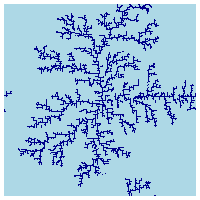

In [3]:
L = 200
r = ceil(div(L, 2)) * 0.9
N = 5000
step = 100_000
system = DLAPlane(L, r, N, step)
DLA!(system)
alarm()
heatmap(system.site)

Progress:  17%|███████                                  |  ETA: 0:00:31

i = 19720
  6.242578 seconds (323.60 k allocations: 32.770 MiB, 0.21% gc time)
system.parameters.ct = 4751


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06



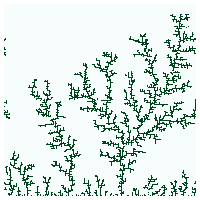

In [7]:
L = 200
N = 5000
step = 100_000
system = Bonsai(L, N, step)
DLA!(system)
alarm()
heatmap(rotr90(system.site), c=:BuGn)


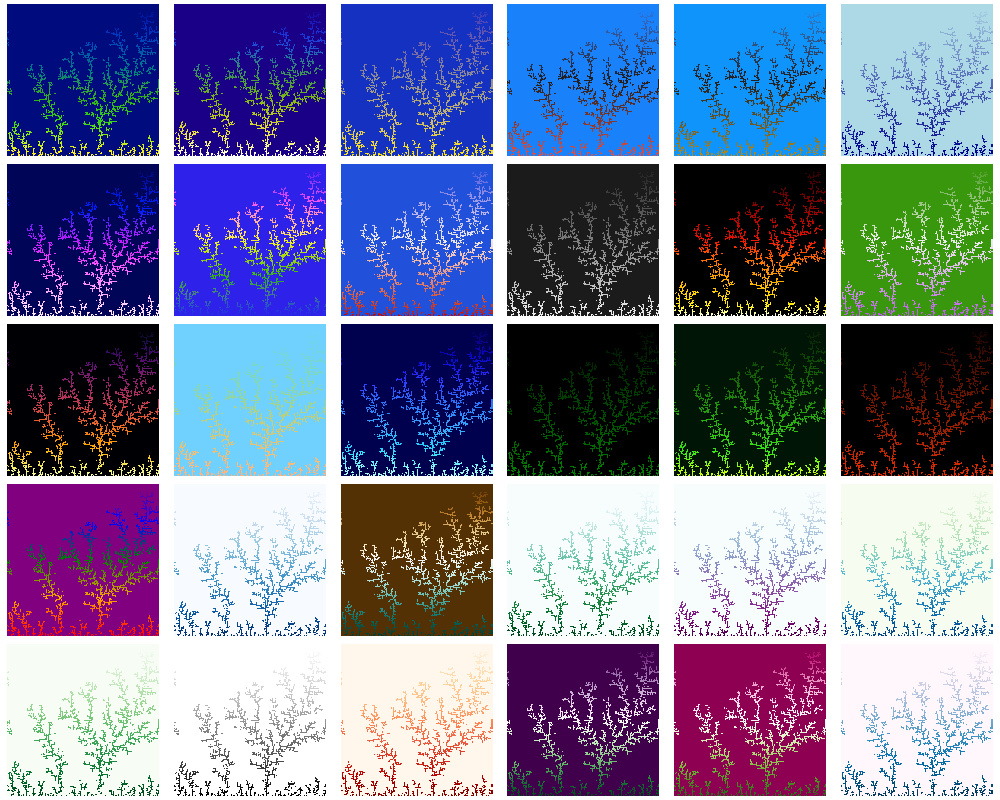

In [8]:
# site = sitecore
site = system.site
l = size(site)[1]
# colorsite = site
colorsite = zeros(Int, l,l)
for i in 1:l, j in 1:l
    if site[i,j]
        colorsite[i,j] = l-j+1
    end
end

a1 = heatmap(rotr90(colorsite), c=:bgy)
a2 = heatmap(rotr90(colorsite), c=:bgyw)
a3 = heatmap(rotr90(colorsite), c=:bjy)
a4 = heatmap(rotr90(colorsite), c=:bkr)
a5 = heatmap(rotr90(colorsite), c=:bky)
a6 = heatmap(rotr90(colorsite), c=:blues)
a7 = heatmap(rotr90(colorsite), c=:bmw)
a8 = heatmap(rotr90(colorsite), c=:colorwheel)
a9 = heatmap(rotr90(colorsite), c=:coolwarm)
a10 = heatmap(rotr90(colorsite), c=:dimgray)
a11 = heatmap(rotr90(colorsite), c=:fire)
a12 = heatmap(rotr90(colorsite), c=:gwv)
a13 = heatmap(rotr90(colorsite), c=:inferno)
a14 = heatmap(rotr90(colorsite), c=:isolum)
a15 = heatmap(rotr90(colorsite), c=:kdc)
a16 = heatmap(rotr90(colorsite), c=:kg)
a17 = heatmap(rotr90(colorsite), c=:kgy)
a18 = heatmap(rotr90(colorsite), c=:kr)
a19 = heatmap(rotr90(colorsite), c=:rainbow)
a20 = heatmap(rotr90(colorsite), c=:Blues)
a21 = heatmap(rotr90(colorsite), c=:BrBG)
a22 = heatmap(rotr90(colorsite), c=:BuGn)
a23 = heatmap(rotr90(colorsite), c=:BuPu)
a24 = heatmap(rotr90(colorsite), c=:GnBu)
a25 = heatmap(rotr90(colorsite), c=:Greens)
a26 = heatmap(rotr90(colorsite), c=:Greys)
a27 = heatmap(rotr90(colorsite), c=:OrRd)
a28 = heatmap(rotr90(colorsite), c=:PRGn)
a29 = heatmap(rotr90(colorsite), c=:PiYG)
a30 = heatmap(rotr90(colorsite), c=:PuBu)

fig = [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, 
    a11, a12, a13, a14, a15, a16, a17, a18, a19,
    a20, a21, a22, a23, a24, a25, a26, a27, a28, a29, a30]
plot(fig..., layout=length(fig), aspect_ratio=:equal, size=(1000, 800))


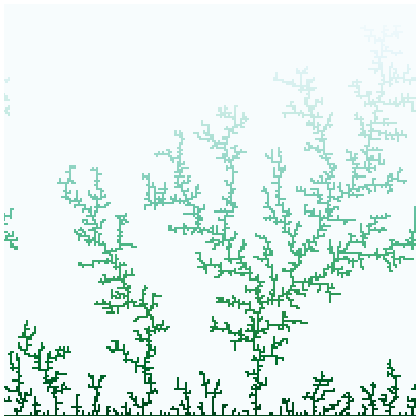

In [9]:
heatmap(rotr90(colorsite), c=:BuGn, size=(420, 420))

# Old version (very slow)

In [23]:
mutable struct Particle
    fix::Bool
    x::Int
    y::Int

    function Particle(x,y)
        new(false, x, y)
    end
end

function DLA(L, r, N, step, d::Int=100)
    if iseven(L)
        error("L have to be odd.")
    end
    dir = Dict(1=>(1,0), 2=>(-1,0), 3=>(0,1), 4=>(0,-1))
    
    cen = div(L,2) + 1
    site = falses(L, L)
    site[cen, cen] = true
    particles = [Particle(round(Int, cen + r*cos(theta)), cen + round(Int, r*sin(theta))) 
                    for theta in linspace(0,2pi, N)]
    ct = 1
    
    function updatepos(particle::Particle)
        if particle.fix
            return
        end

        x, y = particle.x, particle.y
        a, b = dir[rand(1:4)]
        x += a
        y += b

        x = mod1(x, L)
        y = mod1(y, L)

        if any([ site[mod1(x+1, L), y], site[mod1(x-1, L), y], site[x, mod1(y+1, L)], site[x, mod1(y-1, L)] ])
            particle.fix = true
            site[x,y] = true
            ct += 1
        end

        particle.x = x; particle.y = y;

        return
    end
    
    @time @showprogress for i in 1:step
        updatepos.(particles)
        if ct > round(Int, 0.95 * N) && iszero(mod(i,d))
            break
        end
    end
    @show sum(site)

    return site
end


function DLAlin(L, N, step, judge::Int=200)
    if iseven(L)
        error("L have to be odd.")
    end
    
    dir = Dict(1=>(1,0), 2=>(-1,0), 3=>(0,1), 4=>(0,-1))
    
    cen = div(L,2) + 1
    site = falses(L, L)
    site[:,end] = true
    particles = [Particle(mod1(i, L), cen) for i in 1:N]
    ct = 0
    
    function updatepos(particle::Particle)
        if particle.fix
            return
        end

        x, y = particle.x, particle.y
        a, b = dir[rand(1:4)]
        x += a
        if y + b > 0
            y += b
        end

        x = mod1(x, L)
        y = mod1(y, L)

        if any([ site[mod1(x+1, L), y], site[mod1(x-1, L), y], site[x, mod1(y+1, L)] ])
            particle.fix = true
            site[x,y] = true
            ct += 1
        end

        particle.x = x; particle.y = y;

        return
    end
    
    @time @showprogress for i in 1:step
        updatepos.(particles)
        if ct > round(Int, 0.9 * N) && iszero(mod(i,judge))
            break
        end
    end
    @show sum(site)
    heatmap(rotl90(site))
    
    return site
end

DLAlin (generic function with 2 methods)

Progress:  15%|██████                                   |  ETA: 0:06:03

sum(site) = 4746


Progress: 100%|█████████████████████████████████████████| Time: 0:01:04



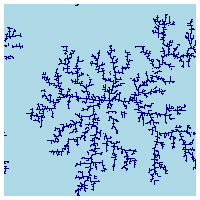

In [24]:
L = 201
r = ceil(div(L, 2))
N = 5000
step = 100_000
sitecore = DLA(L, r, N, step, 200)
alarm()
heatmap(sitecore)

Progress:   6%|██                                       |  ETA: 0:05:30

 20.535886 seconds (71.52 M allocations: 3.205 GiB, 6.00% gc time)
sum(site) = 3605


Progress: 100%|█████████████████████████████████████████| Time: 0:00:21



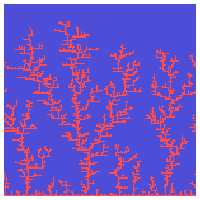

In [25]:
L = 151
N = 4000
step = 100_000
sitelin = DLAlin(L, N, step, 200)
alarm()
heatmap(rotl90(sitelin), c=:lighttest)